In [79]:
# 1. Import thư viện cần thiết
from google.colab import files
uploaded = files.upload()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Saving VNM.csv to VNM.csv


In [80]:
df = pd.read_csv('VNM.csv')
df1=df.reset_index()['Price']

In [81]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1># 4. Split the data into training, testing, and validation arcording to 7:2:1

In [82]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [83]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [84]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [85]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [86]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [87]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 37ms/step - loss: 0.1146 - val_loss: 0.0043
Epoch 2/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 3/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 4/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 5/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 6/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 8/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0011

In [88]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 29ms/step


In [89]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [90]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)


Validation RMSE: 1224.6931142344506
Testing RMSE: 1049.6681790329203
Validate MAE:  868.5231481481482
Test MAE:  773.7799393503291
Validate MAPE:  1.2393753998520527
Test MAPE:  1.0538939692047244


In [92]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.11778835]
101
1 day input [0.13328416 0.1807451  0.19063279 0.17283494 0.19261033 0.18865525
 0.20052049 0.18667771 0.16492478 0.14712693 0.15108201 0.18667771
 0.17876756 0.17283494 0.15899217 0.16294725 0.16096971 0.14712693
 0.13921678 0.1352617  0.14317185 0.14119431 0.12141892 0.14119431
 0.14910447 0.1352617  0.14317185 0.14119431 0.15305955 0.17283494
 0.16096971 0.13723924 0.14119431 0.1352617  0.11350877 0.11350877
 0.1352617  0.12932908 0.125374   0.13130662 0.13328416 0.12339646
 0.14317185 0.125374   0.13921678 0.15305955 0.15305955 0.14910447
 0.13723924 0.1352617  0.12339646 0.13130662 0.11746385 0.11350877
 0.12141892 0.11548631 0.12141892 0.13328416 0.13921678 0.12735154
 0.11944138 0.11153123 0.11350877 0.11350877 0.11153123 0.11350877
 0.12339646 0.12141892 0.13328416 0.125374   0.125374   0.125374
 0.17283494 0.21040818 0.20249803 0.19854295 0.20447557 0.19854295
 0.19261033 0.21238572 0.2163408  0.21238572 0.20249803 0.21238572
 0.23216111 0.2163408  0.21238572 0

In [ ]:
# Reshape x_input to the expected shape

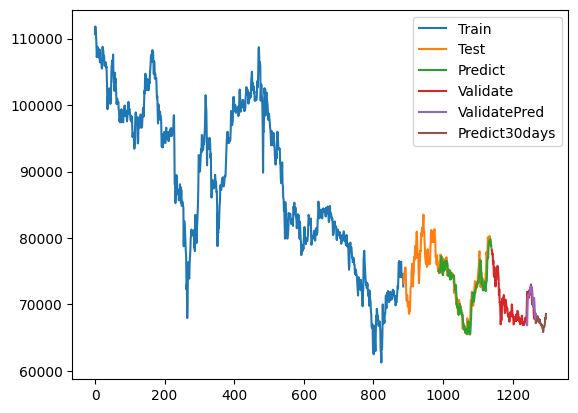

In [93]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

<h1># 4. Split the data into training, testing, and validation arcording to 5:3:2

In [94]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [95]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [96]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [97]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [98]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [99]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 80ms/step - loss: 0.1033 - val_loss: 0.0562
Epoch 2/100
9/9 [==============================] - 0s 40ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 3/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0105 - val_loss: 0.0359
Epoch 4/100
9/9 [==============================] - 0s 48ms/step - loss: 0.0057 - val_loss: 0.0123
Epoch 5/100
9/9 [==============================] - 0s 47ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 11/100
9/9 [=

In [100]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 6ms/step


In [101]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [102]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 1646.176689233986
Testing RMSE: 1873.6813778206467
Validate MAE:  1373.8028492647059
Test MAE:  1512.482092853943
Validate MAPE:  1.9363325761283183
Test MAPE:  2.083608070892209


In [103]:
# 13. Dự báo 30 ngày tiếp theo

x_input=val_data[154:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.14604133]
101
1 day input [0.13328416 0.1807451  0.19063279 0.17283494 0.19261033 0.18865525
 0.20052049 0.18667771 0.16492478 0.14712693 0.15108201 0.18667771
 0.17876756 0.17283494 0.15899217 0.16294725 0.16096971 0.14712693
 0.13921678 0.1352617  0.14317185 0.14119431 0.12141892 0.14119431
 0.14910447 0.1352617  0.14317185 0.14119431 0.15305955 0.17283494
 0.16096971 0.13723924 0.14119431 0.1352617  0.11350877 0.11350877
 0.1352617  0.12932908 0.125374   0.13130662 0.13328416 0.12339646
 0.14317185 0.125374   0.13921678 0.15305955 0.15305955 0.14910447
 0.13723924 0.1352617  0.12339646 0.13130662 0.11746385 0.11350877
 0.12141892 0.11548631 0.12141892 0.13328416 0.13921678 0.12735154
 0.11944138 0.11153123 0.11350877 0.11350877 0.11153123 0.11350877
 0.12339646 0.12141892 0.13328416 0.125374   0.125374   0.125374
 0.17283494 0.21040818 0.20249803 0.19854295 0.20447557 0.19854295
 0.19261033 0.21238572 0.2163408  0.21238572 0.20249803 0.21238572
 0.23216111 0.2163408  0.21238572 0

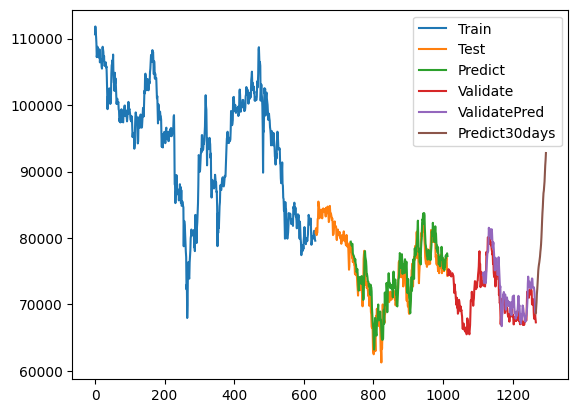

In [104]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


<h1># 4. Split the data into training, testing, and validation arcording to 6:3:1

In [105]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [106]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [107]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [108]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [109]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [110]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 43ms/step - loss: 0.0169 - val_loss: 0.0039
Epoch 2/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 3/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 4/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 5/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 6/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 7/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 8/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 9/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0018

In [111]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 24ms/step


In [112]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [113]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 1553.3681142068358
Testing RMSE: 1578.468663547041
Validate MAE:  1309.6050347222222
Test MAE:  1227.5110495071685
Validate MAPE:  1.8632119166860812
Test MAPE:  1.6406188390412308


In [114]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1



[0.11448734]
101
1 day input [0.13328416 0.1807451  0.19063279 0.17283494 0.19261033 0.18865525
 0.20052049 0.18667771 0.16492478 0.14712693 0.15108201 0.18667771
 0.17876756 0.17283494 0.15899217 0.16294725 0.16096971 0.14712693
 0.13921678 0.1352617  0.14317185 0.14119431 0.12141892 0.14119431
 0.14910447 0.1352617  0.14317185 0.14119431 0.15305955 0.17283494
 0.16096971 0.13723924 0.14119431 0.1352617  0.11350877 0.11350877
 0.1352617  0.12932908 0.125374   0.13130662 0.13328416 0.12339646
 0.14317185 0.125374   0.13921678 0.15305955 0.15305955 0.14910447
 0.13723924 0.1352617  0.12339646 0.13130662 0.11746385 0.11350877
 0.12141892 0.11548631 0.12141892 0.13328416 0.13921678 0.12735154
 0.11944138 0.11153123 0.11350877 0.11350877 0.11153123 0.11350877
 0.12339646 0.12141892 0.13328416 0.125374   0.125374   0.125374
 0.17283494 0.21040818 0.20249803 0.19854295 0.20447557 0.19854295
 0.19261033 0.21238572 0.2163408  0.21238572 0.20249803 0.21238572
 0.23216111 0.2163408  0.21238572 0

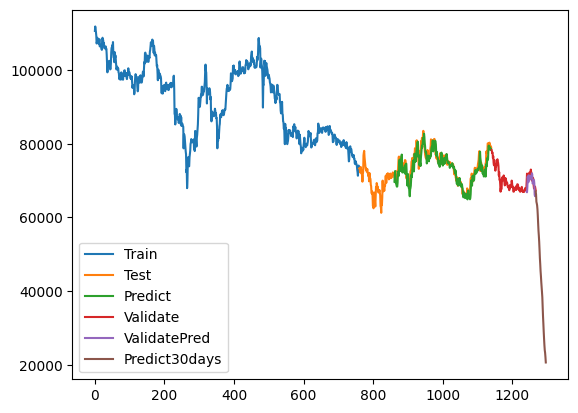

In [115]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()